In [1]:
import numpy as np
import pandas as pd

import keras
from keras import layers


## 데이터 전처리

In [2]:
df = pd.read_csv("data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
df = df.drop('people', axis=1)

In [4]:
df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'label' 컬럼을 숫자로 변환
df['activity'] = label_encoder.fit_transform(df['activity'])


In [6]:
df['activity'].value_counts()

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64

## 트랜스포머 인코더

In [7]:
X = df.drop('activity', axis=1)
y = df['activity']

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from collections import Counter
import numpy as np

def split_sequences(sequences, n_steps):
    X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
    for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
        # find the end of this pattern
        end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
        # check if we are beyond the dataset
        if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
            break  # 범위를 넘으면 루프 종료
        # gather input (X) and output parts (y)
        seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
        seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
        # 가장 빈번하게 나온 레이블 찾기
        most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
        X.append(seq_x)  # 입력 데이터 추가
        y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
    return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

In [10]:
# Merge train and test X/y data to apply sequence transformation function
y_train = np.array(y_train)
train_set = np.c_[X_train, y_train]

y_test = np.array(y_test)
test_set = np.c_[X_test, y_test]

In [11]:
n_step = 10

X_train, y_train = split_sequences(train_set, n_step)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, n_step)
print(X_test.shape, y_test.shape)

(7287, 10, 270) (7287,)
(1815, 10, 270) (1815,)


In [12]:
from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7287, 19)
(1815, 19)


In [13]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

10 270 19


In [14]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [15]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(19, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [16]:
n_classes = len(np.unique(y_train))

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)

input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)
model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping]
)

model.evaluate(X_test, y_test, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 270)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 270)   │  1,109,262 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 270)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 270)   │        540 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 270)   │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 4)     │      1,084 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 270)   │      1,350 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 270)   │        540 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 270)   │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 270)   │  1,109,262 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 270)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 270)   │        540 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 270)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 4)     │      1,084 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 270)   │      1,350 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 270)   │        540 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 270)   │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,262,691 (8.63 MB)

 Trainable params: 2,262,691 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - categorical_accuracy: 0.0623 - loss: 6.0944 - val_categorical_accuracy: 0.1084 - val_loss: 2.8765
Epoch 2/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - categorical_accuracy: 0.1043 - loss: 3.0865 - val_categorical_accuracy: 0.1770 - val_loss: 2.7272
Epoch 3/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - categorical_accuracy: 0.1531 - loss: 2.8273 - val_categorical_accuracy: 0.2044 - val_loss: 2.6978
Epoch 4/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - categorical_accuracy: 0.1950 - loss: 2.7242 - val_categorical_accuracy: 0.2167 - val_loss: 2.6029
Epoch 5/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.2094 - loss: 2.6406 - val_categorical_accuracy: 0.2414 - val_loss: 2.5489
Epoch 6/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - categorical_accuracy: 0.2521 - loss: 2.4840 - val_categorical_accuracy: 0.2414 - val_loss: 2.5130
Epoch 7/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - categorical_accuracy: 0.2449 - lo

[2.0120716094970703, 0.4865013659000397]

기본: [1.977710485458374, 0.40779364109039307]


n_step 3->5: [1.8524069786071777, 0.44010987877845764]

n_step 5->10: [1.8384621143341064, 0.4787878692150116]

n_step 10->15: [2.311615228652954, 0.42817679047584534]

n_step 15->10, block 1->2:
[2.0120716094970703, 0.4865013659000397]

## Dense 레이어 사용한 딥러닝 분류

In [17]:
X = df.drop('activity', axis=1)
y = df['activity']

In [18]:
Y = pd.get_dummies(y).values
Y.shape

(9120, 19)

In [19]:
X = X.values
X

array([[ 7.97571440e+00,  8.16050000e+00,  7.68230000e+00, ...,
         6.77872244e-07,  8.23329973e-04,  3.67289638e-02],
       [ 7.97824960e+00,  8.17630000e+00,  7.84720000e+00, ...,
         7.03230184e-07,  8.38588209e-04,  3.47471027e-01],
       [ 7.97089360e+00,  8.08600000e+00,  7.84700000e+00, ...,
         6.26822162e-07,  7.91721013e-04,  4.55789434e-02],
       ...,
       [ 9.59911289e+00,  2.79300000e+01, -1.07650000e+00, ...,
         2.02610687e-02,  1.42341381e-01,  6.68438219e-01],
       [ 9.69248222e+00,  7.27820000e+01, -2.67340000e+00, ...,
         1.35637914e-02,  1.16463691e-01, -1.48248900e+00],
       [ 9.38064091e+00,  4.50090000e+01, -3.59380000e+00, ...,
         9.35825449e-03,  9.67380716e-02, -2.23302203e-01]])

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

In [21]:
#Defining the model 

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam


model = Sequential()

model.add(Dense(64,input_shape=(X_train.shape[1],),activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

C:\Users\topic\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,571 (248.32 KB)

 Trainable params: 63,571 (248.32 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_history=model.fit(x=X_train, y=y_train, epochs=30, batch_size=32,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6523 - loss: 1.3700 - val_accuracy: 0.9507 - val_loss: 0.2167
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.9633 - loss: 0.1178 - val_accuracy: 0.9715 - val_loss: 0.1016
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.9829 - loss: 0.0601 - val_accuracy: 0.9781 - val_loss: 0.0889
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9805 - loss: 0.0533 - val_accuracy: 0.9775 - val_loss: 0.0782
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.9916 - loss: 0.0280 - val_accuracy: 0.9852 - val_loss: 0.0568
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.9909 - loss: 0.0255 - val_accuracy: 0.9841 - val_loss: 0.0643
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.9932 - loss: 0.0190 - val_accuracy: 0.9874 - val_loss: 0.0597
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.9944 - loss: 0.0202 - val_

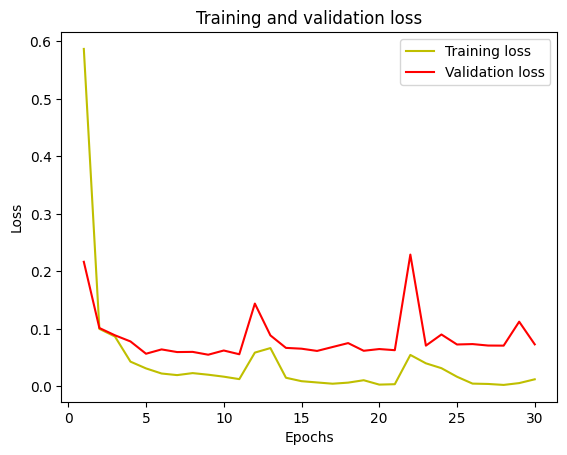

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

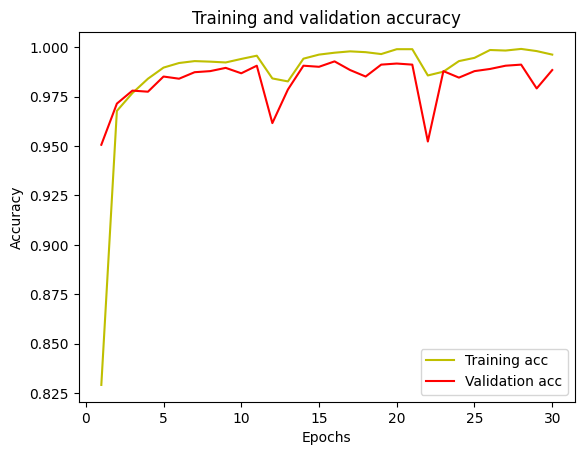

In [24]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:

#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        93
           1       0.99      0.98      0.98       100
           2       1.00      1.00      1.00        92
           3       0.99      0.98      0.98        97
           4       1.00      0.98      0.99       101
           5       1.00      1.00      1.00       109
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00        89
           8       1.00      1.00      1.00       101
           9       0.93      0.94      0.93       106
          10       0.98      1.00      0.99        90
          11       0.99      1.00      0.99        99
          12       1.00      1.00      1.00       103
          13       1.00      1.00      1.00        92
          14       0.93      0.92      0.93        90
          15       1.00      0.99      0.99        92
          16       1.00      0.99      0.99        93
          17       0.99    

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
Confusion Matrix


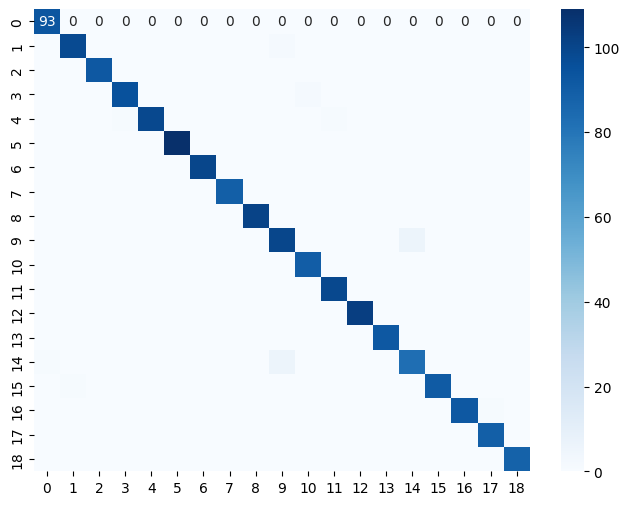

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test, axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
plt.tight_layout()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()